# Model fitting

- training data: $\{x_i, y_i\}_i^I$
- define a model, $f[x_i, \phi]$, parameterized by $\phi$ that maps an input $x_i$ to an output $y_i$
- objective/loss ($L[\phi] = L[x, \phi]$): loss function that estimates how close the model output is to actual value
- fitting: finding the parameters, $\hat \phi$, that minimizes the loss using optimization algorithms i.e 
$$\hat \phi = argmin_{\phi} \ L(x, \phi)$$
- Here we will explore differnt optimization algorithms, SGD, ADAM, ....

We will start by creating a dataset and defining a Gabor model, defined in Chapter 6 of Understanding Deep Learning by Simon P.

$$f[x, \phi] \ = sin[\phi_0 + 0.006\phi_1 x] * e^{-(\frac{\phi_0 + 0.06\phi_1 x}{32.0})}$$

We will generate samples generated using $\phi = [0.0, 16.6]^T$ and fit a model to learn these parameters.

In [18]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
from pathlib import Path
import sys
import os
proj_dir = r"D://learning//understanding_dl"
# add project dir to path
sys.path.append(proj_dir)
# change working dir to project dir
os.chdir(proj_dir)
os.getcwd()

out_dir = Path("D://learning//understanding_dl/data/ch-6")
out_dir.mkdir(parents=True, exist_ok=True)

In [20]:
import math
from argparse import Namespace
from collections import defaultdict
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.optim import AdamW, Adam, SGD
from tqdm import tqdm
import seaborn as sns
from torch.distributions import Uniform, Normal
from torch.utils.data import TensorDataset, DataLoader
from tensordict import TensorDict
from src.visualization import PlotlibViewer
# %matplotlib widget
# from src.visualization import View3D


## create training dataset

In [21]:
def eval_gabor_model(x: torch.Tensor, phi0: float, phi1: float) -> torch.Tensor:
    phase = phi0 + 0.06 *phi1 * x
    f_x_phi = torch.sin(phase) * torch.exp(-1 * (phase ** 2 / 32.0))
    
    return f_x_phi

In [22]:
# number of samples
N = 30
low, high = -15.0, 15.0
u_dist = Uniform(low, high)
phi0, phi1 = 0.0, 16.6
X = u_dist.sample((N, 1)) # N x 1, N sample each having 1 feature
Y = eval_gabor_model(X, phi0, phi1)
# add normally distributed noise

Y = Y + 0.5 * torch.randn_like(Y)

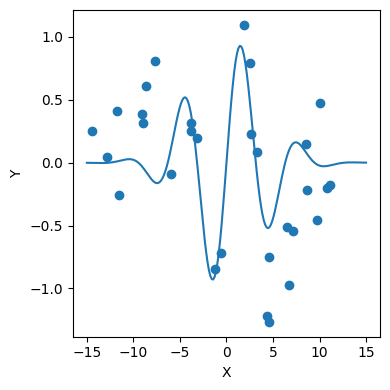

In [23]:
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(111)
# ax = fig.add_subplot(111, projection="3d")
x_ = torch.linspace(low, high, 200)
ax.plot(x_, eval_gabor_model(x_, phi0, phi1))
ax.scatter(X, Y)
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.tight_layout()

plt.savefig(out_dir / "gabor samples.png")

## define Gabor model

In [24]:
class Gabor(nn.Module):
    def __init__(self):
        super().__init__()

        self.phi0 = nn.Parameter(1.5 * torch.randn(1))
        self.phi1 = nn.Parameter(1.5 * torch.randn(1))
    
    def forward(self, x):
        phase = self.phi0 + 0.06 * self.phi1 * x
        f_x_phi = torch.sin(phase) * torch.exp(-1 * (phase ** 2 / 32.0))
        
        return f_x_phi
    
    # def __repr__(self):
    #     return f"{type(self).__name__} Module has phi0 and phi1 parameters!"


## define Adam and SGD optimization algorithms

In [25]:
class AdamCustom:
    def __init__(self, 
                 params, 
                 lr=0.001, 
                 beta=0.9, 
                 gamma=0.99, 
                 eps=1e-08,
                 weight_decay=0.0):
        self.params = list(params)
        self.beta = beta
        self.gamma = gamma
        self.eps = eps
        self.lr = lr
        self.weight_decay = weight_decay

        # initalise first and second moment as zero vectors
        self.mt = [torch.zeros_like(p) for p in self.params]
        self.vt = [torch.zeros_like(p) for p in self.params]

        self.t = 0
    
    
    def update(self):
        with torch.no_grad():
            self.t += 1
            for k, p in enumerate(self.params):
                
                if p.grad is not None:
                    # gradient for the current batch/minbatch
                    g_t = p.grad + self.weight_decay * p # gradient for the 

                    # compute first and second moment estimates of gt 
                    mt = self.beta * self.mt[k] + (1 - self.beta) * g_t
                    vt = self.gamma * self.vt[k] + (1 - self.gamma) * (g_t**2)

                    # store moments EMA 
                    self.mt[k] = mt 
                    self.vt[k] = vt

                    # bias correction; since mt and vt are zero initially
                    mt = mt / (1 - self.beta ** (self.t))
                    vt = vt / (1 - self.gamma ** (self.t))

                    # update: inplace 
                    p.add_(-1 * self.lr * mt / (torch.sqrt(vt) + self.eps ))
                
    def step(self):
        self.update()
    
    def zero_grad(self):
        with torch.no_grad():
            for p in self.params:
                if p.grad is not None:
                    p.grad.zero_()


class SGDCustom:
    def __init__(self, 
                 params, 
                 lr=0.001,
                  weight_decay=0.0 ):
        self.params = list(params)
        self.lr = lr
        self.t = 0
        self.weight_decay = weight_decay

    def step(self):
        with torch.no_grad():
            for p in self.params:
                if p.grad is not None:
                    g_t = p.grad + self.weight_decay * p
                    p.add_(-1 * self.lr * g_t)
        self.t += 1

    def zero_grad(self):
        with torch.no_grad():
            for p in self.params:
                if p.grad is not None:
                    p.grad.zero_()
    

## training loop

In [26]:
def train(model, data_loader, epochs, optimizer, criterion):
    info  = defaultdict(list)
    iter = 0
    for e in tqdm(range(epochs), desc='training'):

        for x, y in data_loader:

            y_pred = model(x)
            loss = criterion(y_pred, y)

            # compute gradient: dloss/dparams
            loss.backward()
            
            #: update params using custom params
            optimizer.step()
            info['epoch'].append(e)
            info['iteration'].append(iter)
            info['loss'].append(loss.item())
            info['params'].append((model.phi0.item(), model.phi1.item()))
            info['params_grad'].append((model.phi0.grad.item(), model.phi1.grad.item()))

            # clear gradients
            optimizer.zero_grad()

            iter += 1

        # if e % 100:
        #     print(f"nll normalisation = {nll_norm}, nll quad = {nll_quad}")
        

    info = {k: torch.tensor(v).detach() for k, v in info.items()}

    return info

def plot_loss(info, title='Loss profile', label='loss', ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)

    ax.plot(info['loss'], label=label)
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.set_title(title)

## hyperparams

In [27]:
epochs = 5000
bs = N
weight_decay = 0.0
lr = 0.001
opt = 'sgd' # adam or sgd


In [28]:
# create training data set
ds = TensorDataset(X, Y)
dl = DataLoader(ds, batch_size=bs, shuffle=True)

# instantiate model and optimizer, matching criteria
model = Gabor()
# optimizer = Adam(model.parameters())
objective = nn.MSELoss()


hist = {}

for k in tqdm(['adam', 'sgd', 'adam_custom', 'sgd_custom'],
              desc='optimizers comparison'):

    # reset model
    model = Gabor()

    # create optimizer AFTER model creation
    if k == 'adam':
        optimizer = Adam(
            model.parameters(),
            lr=lr,
            weight_decay=weight_decay
        )

    elif k == 'sgd':
        optimizer = SGD(
            model.parameters(),
            lr=lr,
            weight_decay=weight_decay
        )

    elif k == 'adam_custom':
        optimizer = AdamCustom(
            model.parameters(),
            lr=lr,
            weight_decay=weight_decay
        )

    elif k == 'sgd_custom':
        optimizer = SGDCustom(
            model.parameters(),
            lr=lr,
            weight_decay=weight_decay
        )

    else:
        raise ValueError(f"Unknown optimizer: {k}")

    # train
    info = train(model, dl, epochs, optimizer, objective)
    hist[k] = info


optimizers comparison: 100%|██████████| 4/4 [00:12<00:00,  3.06s/it]


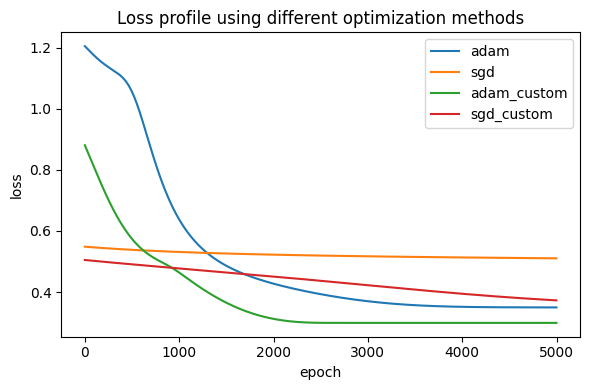

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
for method, data in hist.items():
    ax.plot(data['epoch'], data['loss'], label=method)
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')

ax.set_title('Loss profile using different optimization methods')
plt.tight_layout()
plt.legend()


custom implementations show similar convegence with PyTorch implementations

## Visualisation of loss landscape and optimization trajectory

In [30]:
def get_loss(model, x, y):
    y_pred = eval_gabor_model(x, model.phi0, model.phi1)
    return torch.mean((y_pred - y)**2)

## Evalaute loss on grid of parameters

In [31]:
# define parameter domains
r = 8.
p0, p1 = torch.meshgrid(torch.linspace(-r, r, 100, requires_grad=False), 
                        torch.linspace(-r, r, 100, requires_grad=False), indexing='ij')

# define rows
loss = torch.zeros_like(p0)
rows, cols = p0.shape

# this could be optimized
# compute loss for every possible value of loss
for r in range(rows):
    for c in range(cols):
        
        model = {
            'phi0': p0[r,c], 
            'phi1':p1[r, c]
            }
        
        model = Namespace(**model)
        loss[r, c] = get_loss(model, X, Y)



### contour plots and trajectories

renderer is png


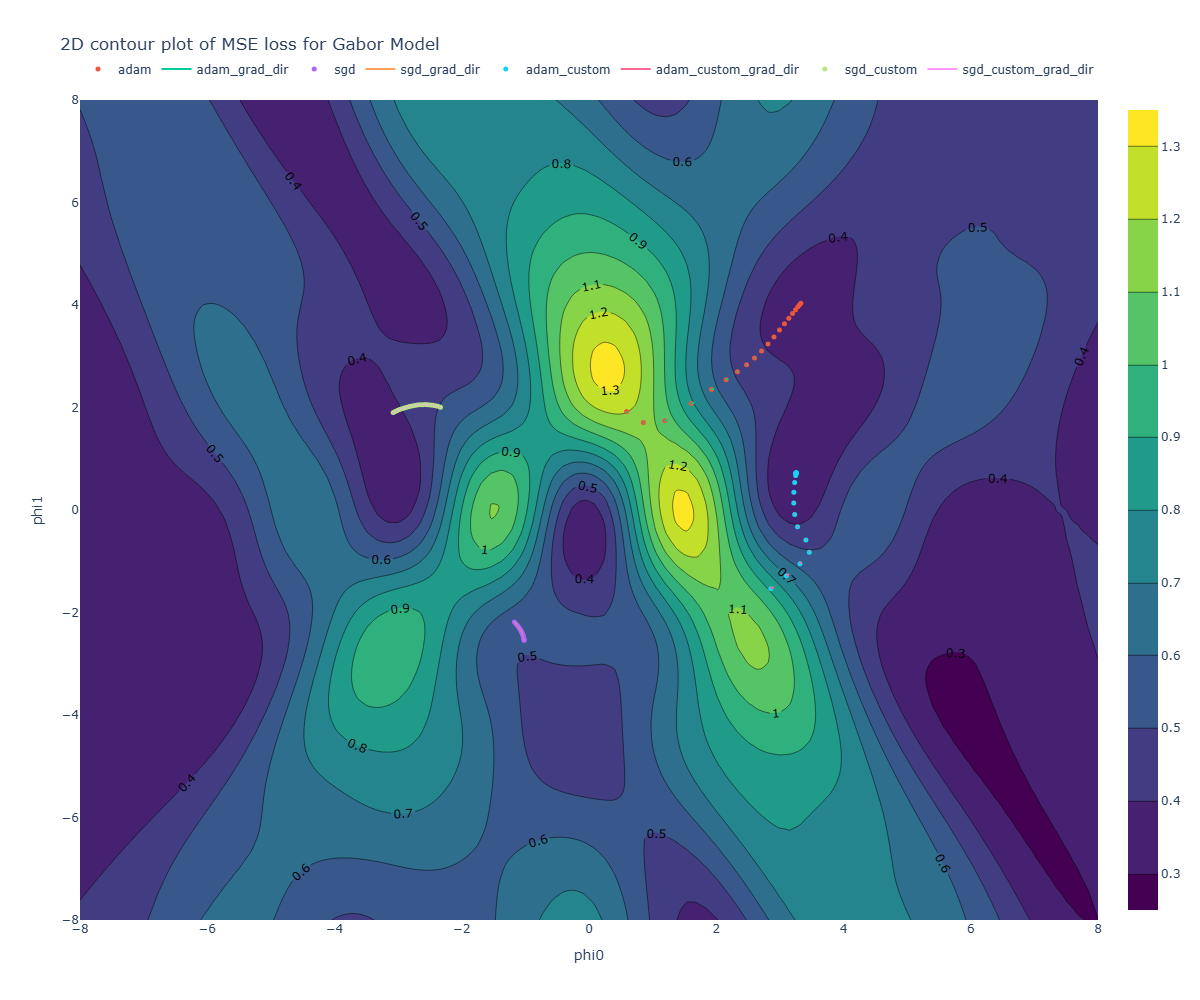

In [ ]:
npoints = 20
cmaps = ['plasma', 'magma', 'solar', 'haline']
renderer = 'png' # png, svg, None
file_name = out_dir / f"loss_2d_viz.{'html' if renderer is None else 'png'}"

# % showing 2d plots
viewer = PlotlibViewer(mode='2d', width=1200, height=1000, renderer=renderer)
viewer.contour(p0.detach().numpy().flatten(), 
               p1.detach().numpy().flatten(), 
               loss.detach().numpy().flatten())

for i, method in enumerate(hist.keys()):
    data = TensorDict(hist[method], batch_size=epochs)
    gap = data['params'].shape[0] // npoints
    data = data[::gap]

    # data['params_grad'] = data['params_grad'] / torch.norm(data['params_grad'], p=2, dim=0)
    viewer.scatter2d(data['params'].numpy()[:, 0].flatten(),
                      data['params'].numpy()[:, 1].flatten(), 
                      name=method,
                    #   color=data['epoch'].numpy(),
                    #   cmap=cmaps[i]
                      )
    viewer.quiver2d(data['params'].numpy()[:, 0].flatten(),
                      data['params'].numpy()[:, 1].flatten(), 
                      -data['params_grad'].numpy()[:, 0].flatten(), 
                      -data['params_grad'].numpy()[:, 1].flatten(),
                      name=method + '_grad_dir'
                      )
    
viewer.show(xlable='phi0', ylabel="phi1", title="2D contour plot of MSE loss for Gabor Model")

viewer.save(file_name)


### surface plots and trajectories

renderer is png


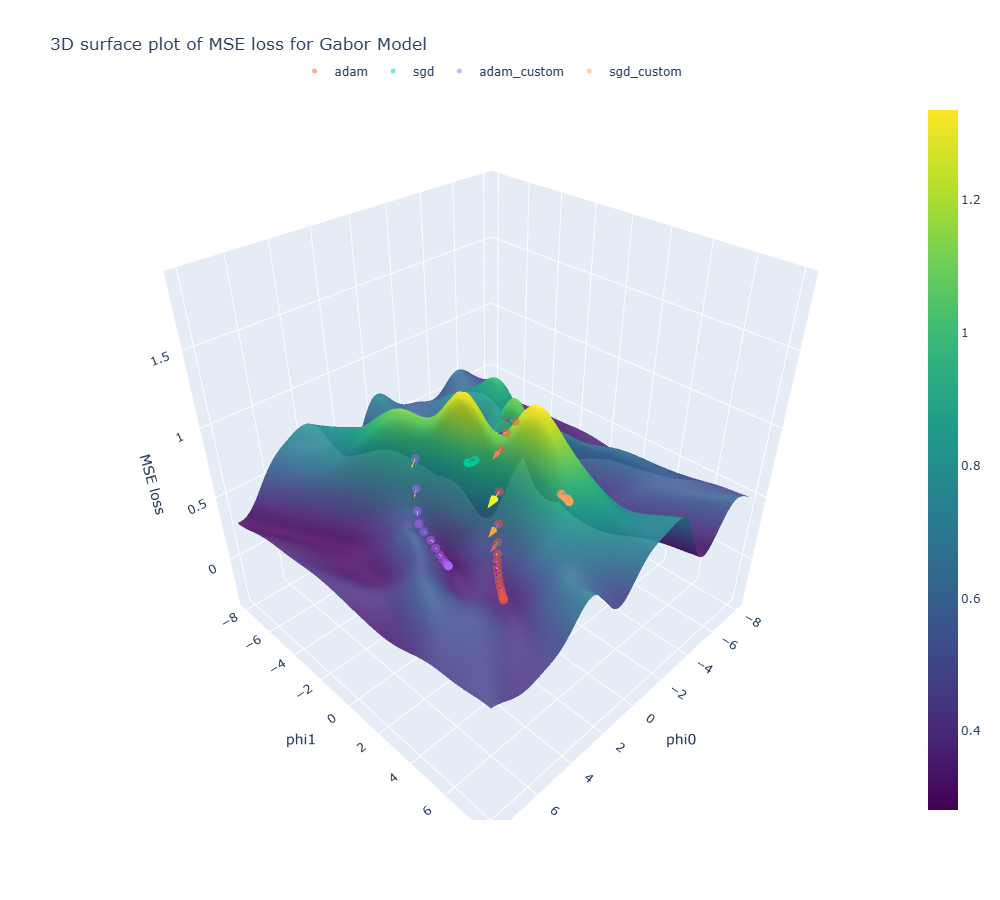

In [45]:

npoints = 20
cmaps = ['plasma', 'magma', 'solar', 'haline']
renderer = 'png' # png, svg, None
file_name = out_dir / f"loss_3d_viz.{'html' if renderer is None else 'png'}"

# % showing 2d plots
viewer = PlotlibViewer(mode='3d', width=1000, height=900, renderer=renderer)
viewer.surface(p0.detach().numpy(), 
               p1.detach().numpy(), 
               loss.detach().numpy(), opacity=0.9)

for i, method in enumerate(hist.keys()):
    data = TensorDict(hist[method], batch_size=epochs)
    gap = data['params'].shape[0] // npoints
    data = data[::gap]

    viewer.scatter3d(
        data['params'].numpy()[:, 0].flatten(),
        data['params'].numpy()[:, 1].flatten(), 
        data['loss'].numpy().flatten(), 
        name=method,
        color=None, # data['epoch'].numpy(),
        cmap=None #cmaps[i]
    )

    # plot trajectory
    # you are moving opposite in the direction of opposite of the gradient
    viewer.quiver3d(
        data['params'].numpy()[:, 0].flatten(),
        data['params'].numpy()[:, 1].flatten(), 
        data['loss'].numpy().flatten(), 
        -data['params_grad'].numpy()[:, 0].flatten(),
        -data['params_grad'].numpy()[:, 1].flatten(),
        torch.zeros_like(data['params_grad'][:, 0]).numpy().flatten() # we don't have gradient in the z-direction
    )
viewer.show(xlable='phi0', ylabel="phi1", zlabel='MSE loss', title="3D surface plot of MSE loss for Gabor Model")


viewer.save(file_name)


The loss curve is not convex, because if you draw a line b/n two points on the loss surface, it is not always above the surface, it some times passes through the surface.

since we are moving in the xy plane, in the parameter space, the direction of the arrow is also in same space.